In [1]:
import pandas as pd
import json
import gensim
import numpy as np
import math

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error

In [25]:
%time w2vM = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
dim = 300

CPU times: user 44.1 s, sys: 5.16 s, total: 49.3 s
Wall time: 57.6 s


In [3]:
%%time
#reviews
#need to build unique train and test sets 
path = 'yelp-recsys-2013/yelp_training_set/yelp_training_set_'

try:
    df_reviews_train = pd.read_pickle('df_reviews_train')
    df_reviews_test = pd.read_pickle('df_reviews_test')
        
    df_business_train = pd.read_pickle('df_business_train')
    df_business_test = pd.read_pickle('df_business_test')
except:
    df_reviews = pd.read_json(path+'review.json', lines=True)

    #filter out empty reviews
    mask = df_reviews['text'].str.len() > 0
    df_reviews = df_reviews.loc[mask]

    df_reviews['text'] = df_reviews['text'].apply(lambda text: text.split())
    df_business = pd.read_json(path+'business.json', lines=True)

    #find unique businesses
    unique_businesses = df_reviews['business_id'].unique()
    train_bus, test_bus = train_test_split(unique_businesses, test_size=0.15)

    df_reviews_train = df_reviews.loc[df_reviews['business_id'].isin(train_bus)]
    df_reviews_test = df_reviews.loc[df_reviews['business_id'].isin(test_bus)]

    df_business_train = df_business.loc[df_business['business_id'].isin(train_bus)]
    df_business_test = df_business.loc[df_business['business_id'].isin(test_bus)]

    #save to files
    df_reviews_train.to_pickle('df_reviews_train')
    df_reviews_test.to_pickle('df_reviews_test')
    
    df_business_train.to_pickle('df_business_train')
    df_business_test.to_pickle('df_business_test')

CPU times: user 6.15 s, sys: 4.35 s, total: 10.5 s
Wall time: 14.3 s


In [22]:
#Used for balanced dataset
path = 'data/yelp/gm_data/yelp/'
try:
    df_reviews_train = pd.read_pickle('df_reviews_train_balanced')
    df_reviews_test = pd.read_pickle('df_reviews_test_balanced')
        
except:
    with open(path+'train.txt', "r") as train_file:
        train_lines = train_file.read().split("\n")
    train_lines = train_lines[:-1]   
        
    train_rows = [line.split('\t') for line in train_lines if line]
    train_labels = []
    train_text = []
    for row in train_rows:
        train_labels.append(int(row[0]))
        train_text.append(row[1])
    
    with open(path+'test.txt', "r") as test_file:
        test_lines = test_file.read().split("\n")
    test_lines = test_lines[:-1]    
    
    test_rows = [line.split('\t') for line in test_lines if line]

    test_labels = []
    test_text = []
    for row in test_rows:
        test_labels.append(int(row[0]))
        test_text.append(row[1])
        
    
    df_reviews_train = pd.DataFrame({'label':train_labels, 'text': train_text})
    df_reviews_test = pd.DataFrame({'label':test_labels, 'text': test_text})


    #save to files
    df_reviews_train.to_pickle('df_reviews_train_balanced')
    df_reviews_test.to_pickle('df_reviews_test_balanced')
    
train_labels = np.array(df_reviews_train[['label']].values).flatten()
test_labels = np.array(df_reviews_test[['label']].values).flatten()
print(train_labels.shape, test_labels.shape)

(600000,) (50000,)


In [4]:
%%time

#build labelarrays
def buildLabelArrays(df):
    labels = []
    for index, row in df.iterrows():
        biz_id = row['business_id']
        biz_row = df_business.loc[df_business['business_id'] == biz_id]
        label = biz_row['stars']
        labels = np.append(labels, label)
        
    return labels

try: 
    train_labels = np.load('train_labels.npy')
    test_labels = np.load('test_labels.npy')
except: #clean this up
    train_labels = buildLabelArrays(df_reviews_train)        
    test_labels = buildLabelArrays(df_reviews_test)
    np.save('train_labels.npy', train_labels)
    np.save('test_labels.npy', test_labels)

CPU times: user 1.96 ms, sys: 6.03 ms, total: 7.99 ms
Wall time: 16.6 ms


In [5]:
print(train_labels.shape)
print(test_labels.shape)

(194844,)
(35057,)


# Visualize Class Balance 


{0: 120000, 1: 120000, 2: 120000, 3: 120000, 4: 120000}
{0: 10000, 1: 10000, 2: 10000, 3: 10000, 4: 10000}
{0: 130000, 1: 130000, 2: 130000, 3: 130000, 4: 130000}


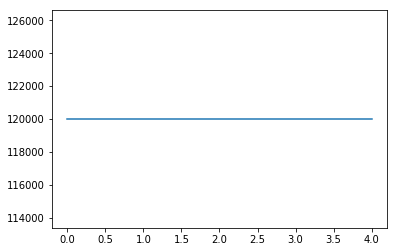

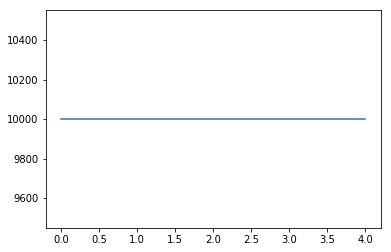

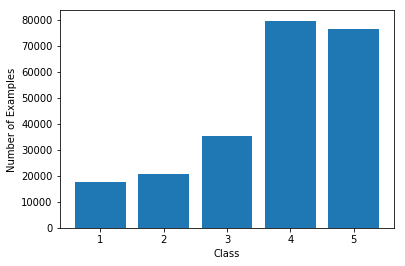

In [23]:

def get_count_dict(arr):
    unique, counts = np.unique(arr, return_counts=True)
    count_dict = dict(zip(unique, counts))
    return count_dict

cd_tr = get_count_dict(train_labels)
cd_test = get_count_dict(test_labels)
total = get_count_dict(np.append(train_labels, test_labels))

print(cd_tr)
print(cd_test)
print(total)

listtr = sorted(cd_tr.items())
x, y = zip(*listtr)
plt.plot(x,y)
plt.show()

listtest = sorted(cd_test.items())
xt, yt = zip(*listtest)
plt.plot(xt,yt)
plt.show()

adjusted_counts = {1: 17567, 2:20615, 3: 35436, 4: 79708, 5:76572}
listtotal = sorted(adjusted_counts.items())
xtot, ytot = zip(*listtotal)
plt.bar(xtot, ytot)
plt.xticks([1,2,3,4,5])
plt.ylabel("Number of Examples")
plt.xlabel("Class")
plt.show()

# Class Balance for Whole Yelp Dataset


In [7]:
def adjust_labels(path, output_name, adjustment):
    full_data = pd.read_csv(path, sep='\t', header=None)
    full_data.columns = ['label', 'text']
    grouped = full_data['label'].value_counts()
    print(grouped)

    full_data['label'] = full_data['label'] + adjustment
    
    grouped = full_data['label'].value_counts()
    print(grouped)
    full_data.to_csv(output_name, header=None, index=False, sep='\t')

In [8]:
adjust_labels('data/yelp/train.txt', 'train.txt', -1)
adjust_labels('data/yelp/test.txt', 'test.txt', -1)
adjust_labels('data/yelp/dev.txt', 'dev.txt', -1)

3    57901
4    54827
2    25670
1    15127
0    12563
Name: label, dtype: int64
 2    57901
 3    54827
 1    25670
 0    15127
-1    12563
Name: label, dtype: int64
3    11909
4    11553
2     5151
1     3167
0     2706
Name: label, dtype: int64
 2    11909
 3    11553
 1     5151
 0     3167
-1     2706
Name: label, dtype: int64
3    10062
4     9808
2     4535
1     2661
0     2247
Name: label, dtype: int64
 2    10062
 3     9808
 1     4535
 0     2661
-1     2247
Name: label, dtype: int64


In [26]:
%%time
N_train = train_labels.size
N_test = test_labels.size
np.seterr(all='print')
    
vecs_train = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((dim,))
                            for t in rev]).mean(axis=0)
                 for rev in df_reviews_train['text']])


vecs_test = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((dim,))
                            for t in rev]).mean(axis=0)
                 for rev in df_reviews_test['text'][:N_test]])

np.save('vecs_train', vecs_train)
np.save('vecs_test', vecs_test)

CPU times: user 28min 42s, sys: 1min 23s, total: 30min 5s
Wall time: 38min 4s


In [8]:
print(vecs_train.shape)
print(vecs_test.shape)
for vec in vecs_train:
    if np.isnan(vec).any():
        print('yes')
        
for vec in vecs_test:
    if np.isnan(vec).any():
        print('yes')

(194844, 300)
(35057, 300)


In [27]:
def getMetrics(model, X_train, X_test, y_train, y_test):
    y_pred_pre_train = model.predict(X_train)
    y_pred_train = np.array(y_pred_pre_train).astype(np.int)
    
    y_pred_pre_test = model.predict(X_test)
    y_pred_test = np.array(y_pred_pre_test).astype(np.int)
    print(y_pred_test)
    print(y_test)
    

    accuracy_train = float(np.sum(y_pred_train == y_train)) / y_train.size
    accuracy_test = float(np.sum(y_pred_test == y_test)) / y_test.size
    
    print("Train accuracy: ", accuracy_train)
    print("Test accuracy: ", accuracy_test)
    print("F1 score: ", f1_score(y_test, y_pred_test, average='weighted'))
    print("MSE: ", mean_squared_error(y_test, y_pred_test))


In [10]:
print((train_labels == 4).sum()/len(train_labels))

0.396778961631


In [28]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_trans = le.transform(train_labels)
test_labels_trans = le.transform(test_labels)

rf = ensemble.RandomForestClassifier()
rf.max_depth = 5

rf.fit(vecs_train, train_labels_trans)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
getMetrics(rf, vecs_train, vecs_test, train_labels_trans, test_labels_trans)


[1 0 2 ..., 2 2 0]
[0 0 0 ..., 3 1 0]
Train accuracy:  0.30663833333333335
Test accuracy:  0.30942
F1 score:  0.301437035337
MSE:  3.12372


In [30]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(vecs_train, train_labels_trans)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [31]:
getMetrics(mlp, vecs_train, vecs_test, train_labels_trans, test_labels_trans)

[0 0 1 ..., 1 1 1]
[0 0 0 ..., 3 1 0]
Train accuracy:  0.354035
Test accuracy:  0.3517
F1 score:  0.34023295828
MSE:  2.66072
